
## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data_utils
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
import sklearn
from torch.utils.data.sampler import SubsetRandomSampler

import sys,os
sys.path.append(os.path.abspath("/mnt/home/yjo10/ceph/CAMELS/MIEST/utils/"))
from imp import reload 
# Change in mymodule/'
import vib_utils
reload(vib_utils)
from vib_utils import *

# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu' # temporarily
# Fix random seeds for reproducibility
seed = 73
#torch.manual_seed(seed)
#np.random.seed(seed)

# TNG+SIMBA+ASTRID

### Data load

In [ ]:
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nIllustrisTNG_for_vib_total.npy")
gcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nSIMBA_for_vib_total.npy")
rcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nAstrid_for_vib_total.npy")
acoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    acoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.r_[gcoef_avg, rcoef_avg, acoef_avg]




fparam = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_IllustrisTNG.txt'
gparams = np.loadtxt(fparam)
gparams = gparams[:,:2] ## only Om and Sig8
fparam = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_SIMBA.txt'
rparams = np.loadtxt(fparam)
rparams = rparams[:,:2] ## only Om and Sig8
fparam = "/mnt/home/fvillaescusa/CAMELS/Results/images_Astrid/params_LH_Astrid.txt" 
aparams = np.loadtxt(fparam)
print(aparams.shape)
aparams = aparams[:,:2] ## only Om and Sig8
params  = np.r_[gparams, rparams, aparams]


print(coef.shape, params.shape)

### Normalizations & Dataset for training

In [51]:
batch_size = 100
validation_split = .2
shuffle_dataset = True
random_seed= 42
index = np.array([ 57,  86, 103, 115, 116, 118, 130, 147,  56,  58,  90,  98, 102,
       104, 108, 110, 119, 121, 127, 131, 195])
inv_index = np.array([True]*513)
inv_index[index] = False


# Creating data indices for training and validation splits:
# Creating data indices for training and validation splits:
y_params   = torch.tensor(params,dtype=torch.float)
y    = torch.zeros((y_params.shape[0],y_params.shape[1]+3))
y[:,:2] = y_params
y[:1000,2] = 1.
y[1000:,3] = 1.
y[1000:,4] = 1.

X = torch.tensor(np.absolute(coef),dtype=torch.float)
dataset      = data_utils.TensorDataset(X, y)
dataset_size = len(dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices,:2])

### Training VIB

In [52]:
# Change in mymodule/'
import vib_utils
reload(vib_utils)
from vib_utils import *

# Hyperparameters
beta   = 1e-3
input_shape  = coef.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 200
epochs = 3000


#vib = linearVIB(input_shape, output_shape,z_dim)
#vib = polyVIB(input_shape, output_shape,z_dim, degree=[1/2,1/4,1,1.5])
vib = NDR(input_shape, output_shape,z_dim, num_models=3)
total_loss, accuracy = train_ndr(vib, train_loader, device, epochs,batch_size,test_dataset)
#del vib

Epoch: 100/3000... Loss: -17.9419... Accuracy: 0.0014... Test Om: 0.121 sig: 0.062
Epoch: 200/3000... Loss: -46.7024... Accuracy: 0.0012... Test Om: 0.083 sig: 0.056
Epoch: 300/3000... Loss: -73.5536... Accuracy: 0.0010... Test Om: 0.103 sig: 0.056
Epoch: 400/3000... Loss: -96.1201... Accuracy: 0.0009... Test Om: 0.089 sig: 0.053
Epoch: 500/3000... Loss: -114.2115... Accuracy: 0.0010... Test Om: 0.079 sig: 0.047
Epoch: 600/3000... Loss: -128.4054... Accuracy: 0.0009... Test Om: 0.084 sig: 0.042
Epoch: 700/3000... Loss: -139.2946... Accuracy: 0.0008... Test Om: 0.069 sig: 0.047
Epoch: 800/3000... Loss: -147.5656... Accuracy: 0.0007... Test Om: 0.071 sig: 0.036
Epoch: 900/3000... Loss: -153.7733... Accuracy: 0.0007... Test Om: 0.074 sig: 0.036
Epoch: 1000/3000... Loss: -158.4284... Accuracy: 0.0007... Test Om: 0.062 sig: 0.036
Epoch: 1100/3000... Loss: -161.8937... Accuracy: 0.0007... Test Om: 0.062 sig: 0.034
Epoch: 1200/3000... Loss: -164.4872... Accuracy: 0.0006... Test Om: 0.062 sig:

KeyboardInterrupt: 

### Bias Test

tensor(0.0319)
tensor(-0.0028)
tensor(0.0535) 0.9490509129113381
tensor(0.0312) 0.9180103752293048
tensor(-0.0166)
tensor(-0.0063)
tensor(0.0634) 0.9520023249172881
tensor(0.0350) 0.9154582802918196


/tmp/ipykernel_993724/1202150582.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tng_pred,y_sigma = vib(torch.tensor(x_tng,dtype=torch.float).to(device))
/tmp/ipykernel_993724/1202150582.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_sim_pred,y_sigma = vib(torch.tensor(x_sim,dtype=torch.float).to(device))


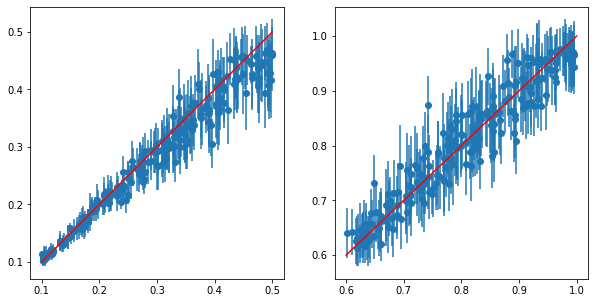

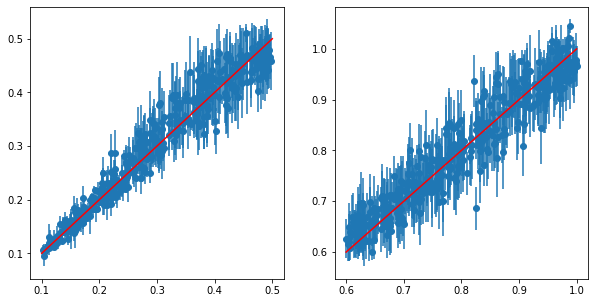

In [55]:
vib.eval()
val_indices = np.array(val_indices)
x_tng, y_tng = X[val_indices[val_indices<1000]], y[val_indices[val_indices<1000],:2]
x_sim, y_sim = X[val_indices[val_indices>1000]], y[val_indices[val_indices>1000],:2]

y_tng_pred,y_sigma = vib(torch.tensor(x_tng,dtype=torch.float).to(device))
y_tng_pred = y_tng_pred.cpu().detach().numpy()
y_sigma    = np.abs(y_sigma.cpu().detach().numpy())

rel1 = (y_tng[:,0]-y_tng_pred[:,0])/y_tng[:,0]
rel2 = (y_tng[:,1]-y_tng_pred[:,1])/y_tng[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_tng[:,0]-y_tng_pred[:,0])/y_tng[:,0]
rel2 = np.abs(y_tng[:,1]-y_tng_pred[:,1])/y_tng[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_tng[:,0],y_tng_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_tng[:,1],y_tng_pred[:,1]))



fig = plt.figure(figsize=(10,5))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)
fig.add_subplot(1,2,1)
plt.scatter(y_tng[:,0],y_tng_pred[:,0])
plt.errorbar(y_tng[:,0],y_tng_pred[:,0],2*y_sigma[:,0],linestyle="None")#, s=1)
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y_tng[:,1],y_tng_pred[:,1])
plt.errorbar(y_tng[:,1],y_tng_pred[:,1],2*y_sigma[:,1],linestyle="None")#, s=1)
plt.plot(ideal2,ideal2,"r")





y_sim_pred,y_sigma = vib(torch.tensor(x_sim,dtype=torch.float).to(device))
y_sim_pred = y_sim_pred.cpu().detach().numpy()
y_sigma    = np.abs(y_sigma.cpu().detach().numpy())

rel1 = (y_sim[:,0]-y_sim_pred[:,0])/y_sim[:,0]
rel2 = (y_sim[:,1]-y_sim_pred[:,1])/y_sim[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_sim[:,0]-y_sim_pred[:,0])/y_sim[:,0]
rel2 = np.abs(y_sim[:,1]-y_sim_pred[:,1])/y_sim[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_sim[:,0],y_sim_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_sim[:,1],y_sim_pred[:,1]))

fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.scatter(y_sim[:,0],y_sim_pred[:,0])
plt.errorbar(y_sim[:,0],y_sim_pred[:,0],2*y_sigma[:,0],linestyle="None")#, s=1)
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y_sim[:,1],y_sim_pred[:,1])
plt.errorbar(y_sim[:,1],y_sim_pred[:,1],2*y_sigma[:,1],linestyle="None")#, s=1)
plt.plot(ideal2,ideal2,"r")

In [ ]:
vib.eval()
val_indices = np.array(val_indices)

# Creating data indices for training and validation splits:
y_sim = torch.tensor(aparams,dtype=torch.float)
x_sim = torch.tensor(np.absolute(acoef_avg),dtype=torch.float)


y_tng_pred, y_sigma = vib(torch.tensor(x_sim,dtype=torch.float).to(device))
y_tng_pred = y_tng_pred.cpu().detach().numpy()
y_sigma    = 2*np.abs(y_sigma.cpu().detach().numpy())



rel1 = (y_sim[:,0]-y_tng_pred[:,0])/y_sim[:,0]
rel2 = (y_sim[:,1]-y_tng_pred[:,1])/y_sim[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_sim[:,0]-y_tng_pred[:,0])/y_sim[:,0]
rel2 = np.abs(y_sim[:,1]-y_tng_pred[:,1])/y_sim[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_sim[:,0],y_tng_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_sim[:,1],y_tng_pred[:,1]))


fig = plt.figure(figsize=(10,5))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)
fig.add_subplot(1,2,1)
#plt.scatter(y_sim[:,0],y_tng_pred[:,0])
plt.errorbar(y_sim[:,0],y_tng_pred[:,0],y_sigma[:,0],linestyle="None")#, s=1)
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
#plt.scatter(y_sim[:,1],y_tng_pred[:,1])
plt.errorbar(y_sim[:,1],y_tng_pred[:,1],y_sigma[0,1],linestyle="None")#, s=1)
plt.plot(ideal2,ideal2,"r")

tensor(0.0245)
tensor(0.0032)
tensor(0.0703) 0.9420157467970836
tensor(0.0356) 0.8975825531009923
tensor(-0.0287)
tensor(-0.0010)
tensor(0.0772) 0.9424787271487497
tensor(0.0371) 0.9080555011790179


/tmp/ipykernel_456868/1883523457.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tng_pred, _, _ = vib(torch.tensor(x_tng,dtype=torch.float).to(device))
/tmp/ipykernel_456868/1883523457.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_sim_pred, _, _ = vib(torch.tensor(x_sim,dtype=torch.float).to(device))


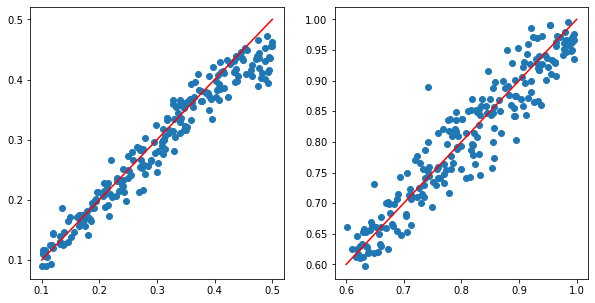

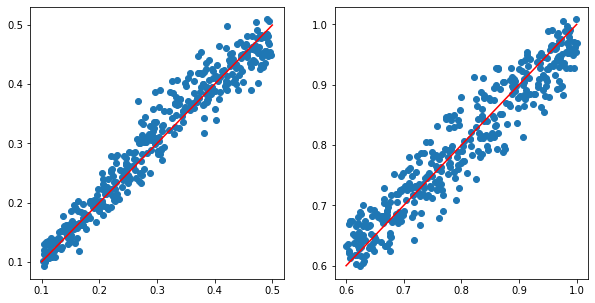

In [12]:
vib.eval()
val_indices = np.array(val_indices)
x_tng, y_tng = X[val_indices[val_indices<1000]], y[val_indices[val_indices<1000]]
x_sim, y_sim = X[val_indices[val_indices>1000]], y[val_indices[val_indices>1000]]

y_tng_pred, _, _ = vib(torch.tensor(x_tng,dtype=torch.float).to(device))
y_tng_pred = y_tng_pred.cpu().detach().numpy()


rel1 = (y_tng[:,0]-y_tng_pred[:,0])/y_tng[:,0]
rel2 = (y_tng[:,1]-y_tng_pred[:,1])/y_tng[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_tng[:,0]-y_tng_pred[:,0])/y_tng[:,0]
rel2 = np.abs(y_tng[:,1]-y_tng_pred[:,1])/y_tng[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_tng[:,0],y_tng_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_tng[:,1],y_tng_pred[:,1]))



fig = plt.figure(figsize=(10,5))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)
fig.add_subplot(1,2,1)
plt.scatter(y_tng[:,0],y_tng_pred[:,0])
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y_tng[:,1],y_tng_pred[:,1])
plt.plot(ideal2,ideal2,"r")





y_sim_pred, _, _ = vib(torch.tensor(x_sim,dtype=torch.float).to(device))
y_sim_pred = y_sim_pred.cpu().detach().numpy()


rel1 = (y_sim[:,0]-y_sim_pred[:,0])/y_sim[:,0]
rel2 = (y_sim[:,1]-y_sim_pred[:,1])/y_sim[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_sim[:,0]-y_sim_pred[:,0])/y_sim[:,0]
rel2 = np.abs(y_sim[:,1]-y_sim_pred[:,1])/y_sim[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_sim[:,0],y_sim_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_sim[:,1],y_sim_pred[:,1]))

fig = plt.figure(figsize=(10,5))
fig.add_subplot(1,2,1)
plt.scatter(y_sim[:,0],y_sim_pred[:,0])
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
plt.scatter(y_sim[:,1],y_sim_pred[:,1])
plt.plot(ideal2,ideal2,"r")

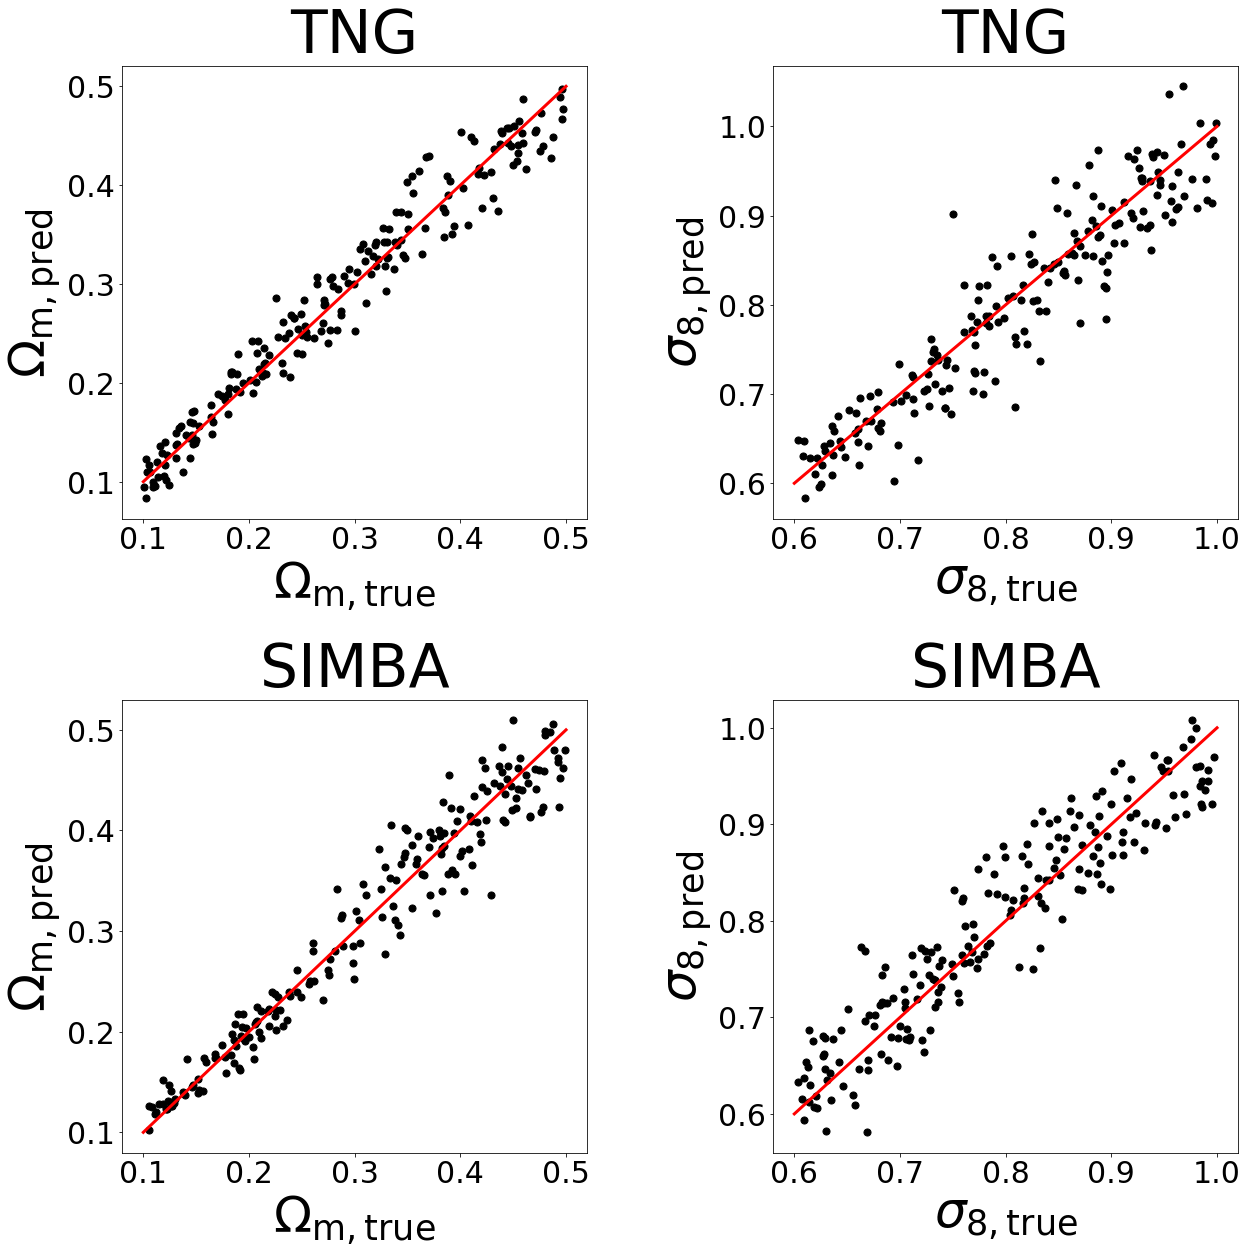

In [98]:
plt.rcParams['font.size'] = '50'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'sans-serif'
plt.rcParams['xtick.labelsize'] = '30'
plt.rcParams['ytick.labelsize'] = '30'

fig = plt.figure(figsize=(20,20))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)

fig.add_subplot(2,2,1)
plt.scatter(y_tng[:,0],y_tng_pred[:,0],s=50,c='k')
plt.plot(ideal1,ideal1,"r",lw=3)
plt.xlabel("$\Omega_\mathrm{m, true}$")
plt.ylabel("$\Omega_\mathrm{m, pred}$")
plt.title('TNG')
fig.add_subplot(2,2,2)
plt.scatter(y_tng[:,1],y_tng_pred[:,1],s=50,c='k')
plt.plot(ideal2,ideal2,"r",lw=3)
plt.xlabel("$\sigma_\mathrm{8, true}$")
plt.ylabel("$\sigma_\mathrm{8, pred}$")
plt.title('TNG')

fig.add_subplot(2,2,3)
plt.scatter(y_sim[:,0],y_sim_pred[:,0],s=50,c='k')
plt.plot(ideal1,ideal1,"r",lw=3)
plt.xlabel("$\Omega_\mathrm{m, true}$")
plt.ylabel("$\Omega_\mathrm{m, pred}$")
plt.title('SIMBA')
fig.add_subplot(2,2,4)
plt.scatter(y_sim[:,1],y_sim_pred[:,1],s=50,c='k')
plt.plot(ideal2,ideal2,"r",lw=3)
plt.xlabel("$\sigma_\mathrm{8, true}$")
plt.ylabel("$\sigma_\mathrm{8, pred}$")
plt.title('SIMBA')

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig("TNG_SIMBA_VIB.png", bbox_inches="tight", dpi=300)

# TNG+SIMBA -> ASTRID

In [2]:
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nIllustrisTNG_for_vib_total.npy")
gcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nSIMBA_for_vib_total.npy")
rcoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nAstrid_for_vib_total.npy")
acoef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    acoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
coef = np.r_[gcoef_avg, rcoef_avg]#, acoef_avg]




fparam = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_IllustrisTNG.txt'
gparams = np.loadtxt(fparam)
gparams = gparams[:,:2] ## only Om and Sig8
fparam = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_SIMBA.txt'
rparams = np.loadtxt(fparam)
rparams = rparams[:,:2] ## only Om and Sig8
fparam = "/mnt/home/fvillaescusa/CAMELS/Results/images_Astrid/params_LH_Astrid.txt" 
aparams = np.loadtxt(fparam)
print(aparams.shape)
aparams = aparams[:,:2] ## only Om and Sig8
params  = np.r_[gparams, rparams]#, aparams]


print(coef.shape, params.shape)

/tmp/ipykernel_469257/1455623027.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  gcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)
/tmp/ipykernel_469257/1455623027.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  rcoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


(1000, 6)
(2000, 513) (2000, 2)


/tmp/ipykernel_469257/1455623027.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  acoef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


In [3]:
batch_size = 100
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
y_params   = torch.tensor(params,dtype=torch.float)
y    = torch.zeros((y_params.shape[0],y_params.shape[1]+2))
y[:,:2] = y_params
y[:1000,2] = 1.
y[1000:,3] = 1.
X = torch.tensor(np.absolute(coef),dtype=torch.float)
dataset      = data_utils.TensorDataset(X, y)
dataset_size = len(dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices,:2])

In [11]:
# Change in mymodule/'
import vib_utils
reload(vib_utils)
from vib_utils import *

# Hyperparameters
beta   = 10
input_shape  = coef.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 200
epochs = 3000


#vib = linearVIB(input_shape, output_shape,z_dim)
#vib = polyVIB(input_shape, output_shape,z_dim, degree=[1/2,1/4,1,1.5])
vib = NDR(input_shape, output_shape,z_dim, num_models=2)
total_loss, accuracy = train_ndr(vib, train_loader, device, epochs,batch_size,test_dataset,beta=beta)
#del vib

/mnt/home/yjo10/ceph/CAMELS/MIEST/utils/vib_utils.py:655: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred, y_sigma = vib(torch.tensor(X,dtype=torch.float).to(device))


Epoch: 100/3000... Loss: -4004.6767... Accuracy: 0.0012... Test Om: 0.078 sig: 0.060
Epoch: 200/3000... Loss: -10380.5608... Accuracy: 0.0010... Test Om: 0.088 sig: 0.047
Epoch: 300/3000... Loss: -16295.1236... Accuracy: 0.0010... Test Om: 0.094 sig: 0.043
Epoch: 400/3000... Loss: -21191.8231... Accuracy: 0.0007... Test Om: 0.062 sig: 0.040
Epoch: 500/3000... Loss: -25072.3890... Accuracy: 0.0006... Test Om: 0.058 sig: 0.039
Epoch: 600/3000... Loss: -28076.8963... Accuracy: 0.0006... Test Om: 0.061 sig: 0.050
Epoch: 700/3000... Loss: -30369.8697... Accuracy: 0.0005... Test Om: 0.060 sig: 0.043
Epoch: 800/3000... Loss: -32102.4078... Accuracy: 0.0004... Test Om: 0.058 sig: 0.044
Epoch: 900/3000... Loss: -33402.5359... Accuracy: 0.0003... Test Om: 0.064 sig: 0.045
Epoch: 1000/3000... Loss: -34373.6820... Accuracy: 0.0003... Test Om: 0.062 sig: 0.046
Epoch: 1100/3000... Loss: -35097.0826... Accuracy: 0.0002... Test Om: 0.063 sig: 0.047
Epoch: 1200/3000... Loss: -35634.6672... Accuracy: 0.

### log(J1+J2)

tensor(-0.1290)
tensor(0.0268)
tensor(0.1437) 0.7950013216881195
tensor(0.0667) 0.6416789000162091


/tmp/ipykernel_469257/2506438925.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tng_pred, y_sigma = vib(torch.tensor(x_sim,dtype=torch.float).to(device))


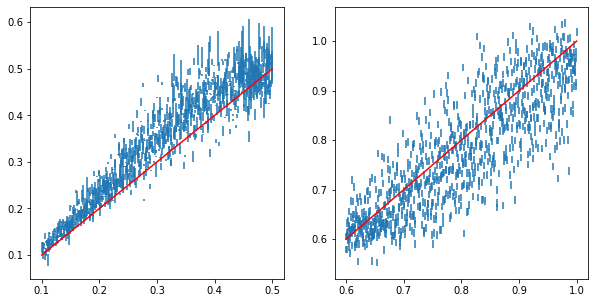

In [12]:
vib.eval()
val_indices = np.array(val_indices)

# Creating data indices for training and validation splits:
y_sim = torch.tensor(aparams,dtype=torch.float)
x_sim = torch.tensor(np.absolute(acoef_avg),dtype=torch.float)


y_tng_pred, y_sigma = vib(torch.tensor(x_sim,dtype=torch.float).to(device))
y_tng_pred = y_tng_pred.cpu().detach().numpy()
y_sigma    = 2*np.abs(y_sigma.cpu().detach().numpy())



rel1 = (y_sim[:,0]-y_tng_pred[:,0])/y_sim[:,0]
rel2 = (y_sim[:,1]-y_tng_pred[:,1])/y_sim[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_sim[:,0]-y_tng_pred[:,0])/y_sim[:,0]
rel2 = np.abs(y_sim[:,1]-y_tng_pred[:,1])/y_sim[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_sim[:,0],y_tng_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_sim[:,1],y_tng_pred[:,1]))


fig = plt.figure(figsize=(10,5))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)
fig.add_subplot(1,2,1)
#plt.scatter(y_sim[:,0],y_tng_pred[:,0])
plt.errorbar(y_sim[:,0],y_tng_pred[:,0],y_sigma[:,0],linestyle="None")#, s=1)
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
#plt.scatter(y_sim[:,1],y_tng_pred[:,1])
plt.errorbar(y_sim[:,1],y_tng_pred[:,1],y_sigma[0,1],linestyle="None")#, s=1)
plt.plot(ideal2,ideal2,"r")

### J1+J2

tensor(-0.1191)
tensor(0.0327)
tensor(0.1248) 0.843969317569023
tensor(0.0525) 0.7716856362224676


/tmp/ipykernel_993724/2506438925.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tng_pred, y_sigma = vib(torch.tensor(x_sim,dtype=torch.float).to(device))


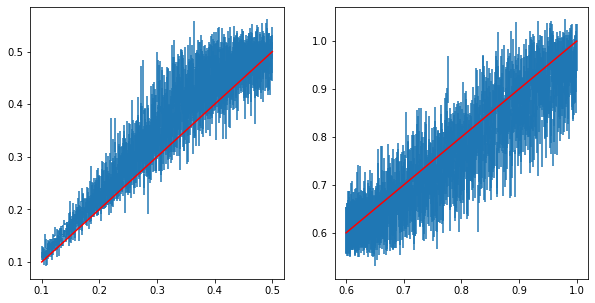

In [42]:
vib.eval()
val_indices = np.array(val_indices)

# Creating data indices for training and validation splits:
y_sim = torch.tensor(aparams,dtype=torch.float)
x_sim = torch.tensor(np.absolute(acoef_avg),dtype=torch.float)


y_tng_pred, y_sigma = vib(torch.tensor(x_sim,dtype=torch.float).to(device))
y_tng_pred = y_tng_pred.cpu().detach().numpy()
y_sigma    = 2*np.abs(y_sigma.cpu().detach().numpy())



rel1 = (y_sim[:,0]-y_tng_pred[:,0])/y_sim[:,0]
rel2 = (y_sim[:,1]-y_tng_pred[:,1])/y_sim[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_sim[:,0]-y_tng_pred[:,0])/y_sim[:,0]
rel2 = np.abs(y_sim[:,1]-y_tng_pred[:,1])/y_sim[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_sim[:,0],y_tng_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_sim[:,1],y_tng_pred[:,1]))


fig = plt.figure(figsize=(10,5))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)
fig.add_subplot(1,2,1)
#plt.scatter(y_sim[:,0],y_tng_pred[:,0])
plt.errorbar(y_sim[:,0],y_tng_pred[:,0],y_sigma[:,0],linestyle="None")#, s=1)
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
#plt.scatter(y_sim[:,1],y_tng_pred[:,1])
plt.errorbar(y_sim[:,1],y_tng_pred[:,1],y_sigma[0,1],linestyle="None")#, s=1)
plt.plot(ideal2,ideal2,"r")

# TNG+ASTRID -> SIMBA

In [13]:
coef = np.r_[gcoef_avg, acoef_avg]#, acoef_avg]
params  = np.r_[gparams, aparams]#, aparams]
print(coef.shape, params.shape)

(2000, 513) (2000, 2)


In [14]:
batch_size = 100
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
y_params   = torch.tensor(params,dtype=torch.float)
y    = torch.zeros((y_params.shape[0],y_params.shape[1]+2))
y[:,:2] = y_params
y[:1000,2] = 1.
y[1000:,3] = 1.
X = torch.tensor(np.absolute(coef),dtype=torch.float)
dataset      = data_utils.TensorDataset(X, y)
dataset_size = len(dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices,:2])


In [24]:
# Change in mymodule/'
import vib_utils
reload(vib_utils)
from vib_utils import *

# Hyperparameters
beta   = 1e-3
input_shape  = coef.shape[1]
output_shape = 2
learning_rate = 1e-3
decay_rate = 0.97
z_dim = 200
epochs = 3000


#vib = linearVIB(input_shape, output_shape,z_dim)
#vib = polyVIB(input_shape, output_shape,z_dim, degree=[1/2,1/4,1,1.5])
vib = NDR(input_shape, output_shape,z_dim, num_models=2)
total_loss, accuracy = train_ndr(vib, train_loader, device, epochs,batch_size,test_dataset)
#del vib

Epoch: 100/3000... Loss: -3.4002... Accuracy: 0.0017... Test Om: 0.140 sig: 0.072
Epoch: 200/3000... Loss: -10.0150... Accuracy: 0.0012... Test Om: 0.148 sig: 0.059
Epoch: 300/3000... Loss: -16.0315... Accuracy: 0.0011... Test Om: 0.086 sig: 0.052
Epoch: 400/3000... Loss: -20.9753... Accuracy: 0.0010... Test Om: 0.100 sig: 0.050
Epoch: 500/3000... Loss: -24.8277... Accuracy: 0.0011... Test Om: 0.078 sig: 0.050
Epoch: 600/3000... Loss: -27.9240... Accuracy: 0.0010... Test Om: 0.085 sig: 0.045
Epoch: 700/3000... Loss: -30.1836... Accuracy: 0.0010... Test Om: 0.115 sig: 0.053
Epoch: 800/3000... Loss: -32.0012... Accuracy: 0.0009... Test Om: 0.069 sig: 0.044
Epoch: 900/3000... Loss: -33.2890... Accuracy: 0.0009... Test Om: 0.067 sig: 0.046
Epoch: 1000/3000... Loss: -34.3029... Accuracy: 0.0008... Test Om: 0.079 sig: 0.045
Epoch: 1100/3000... Loss: -35.0321... Accuracy: 0.0008... Test Om: 0.065 sig: 0.039
Epoch: 1200/3000... Loss: -35.5725... Accuracy: 0.0008... Test Om: 0.065 sig: 0.039
Ep

tensor(0.0824)
tensor(-0.0706)
tensor(0.0942) 0.8813520000181535
tensor(0.0753) 0.6476438909068309


/tmp/ipykernel_993724/3525909973.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_tng_pred, y_sigma = vib(torch.tensor(x_sim,dtype=torch.float).to(device))


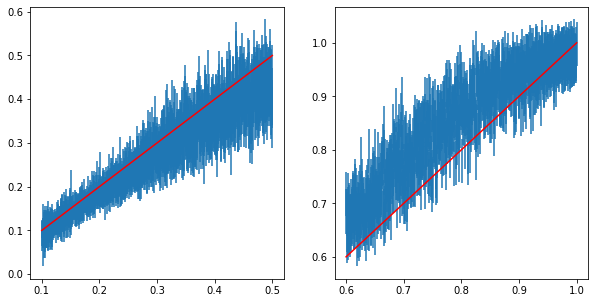

In [37]:
vib.eval()
val_indices = np.array(val_indices)

# Creating data indices for training and validation splits:
y_sim = torch.tensor(rparams,dtype=torch.float)
x_sim = torch.tensor(np.absolute(rcoef_avg),dtype=torch.float)


y_tng_pred, y_sigma = vib(torch.tensor(x_sim,dtype=torch.float).to(device))
y_tng_pred = y_tng_pred.cpu().detach().numpy()
y_sigma    = 2*np.sqrt(np.abs(y_sigma.cpu().detach().numpy()))



rel1 = (y_sim[:,0]-y_tng_pred[:,0])/y_sim[:,0]
rel2 = (y_sim[:,1]-y_tng_pred[:,1])/y_sim[:,1]
print(rel1.mean())
print(rel2.mean())

rel1 = np.abs(y_sim[:,0]-y_tng_pred[:,0])/y_sim[:,0]
rel2 = np.abs(y_sim[:,1]-y_tng_pred[:,1])/y_sim[:,1]
print(rel1.mean(),sklearn.metrics.r2_score(y_sim[:,0],y_tng_pred[:,0]))
print(rel2.mean(),sklearn.metrics.r2_score(y_sim[:,1],y_tng_pred[:,1]))


fig = plt.figure(figsize=(10,5))
ideal1 = np.linspace(0.1,0.5,3)
ideal2 = np.linspace(0.6,1.0,3)
fig.add_subplot(1,2,1)
#plt.scatter(y_sim[:,0],y_tng_pred[:,0])
plt.errorbar(y_sim[:,0],y_tng_pred[:,0],y_sigma[:,0],linestyle="None")#, s=1)
plt.plot(ideal1,ideal1,"r")
fig.add_subplot(1,2,2)
#plt.scatter(y_sim[:,1],y_tng_pred[:,1])
plt.errorbar(y_sim[:,1],y_tng_pred[:,1],y_sigma[0,1],linestyle="None")#, s=1)
plt.plot(ideal2,ideal2,"r")